# Вступление

Сердечно-сосудистые заболевания (ССЗ) являются причиной смерти № 1 во всем мире, унося, по оценкам, 17,9 миллиона жизней каждый год, что составляет 31% всех смертей в мире.

Сердечная недостаточность - это распространенное событие, вызванное ССЗ, и этот набор данных содержит 12 признаков, которые могут быть использованы для прогнозирования смертности от сердечной недостаточности:

* age - Возраст пациента, (40, ..., 95) лет
* sex - Пол пациента, мужчина/женщина
* anaemia - Снижение количества эритроцитов или гемоглобина (уровень гематокрита был ниже 36%), да/нет
* diabetes - Наличие у пациента сахарного диабета, да/нет
* smoking - Курящий пациент, да/нет
* creatinine_phosphokinase - Уровень фермента креатинфосфокиназа (КФК) в крови, (23, ..., 7861) мкг/л
* high_blood_pressure - Наличие у пациента гипертонии, да/нет
* ejection_fraction - Процент крови, покидающей сердце при каждом сокращении, (14, ..., 80) %
* platelets - Уровень тромбоцитов в крови, (25.01, ..., 850.00) кровяных пластинок на 1 мкл крови
* serum_creatinine - Уровень креатинина в сыворотке,	(0.50, ..., 9.40) мг/дЛ
* serum_sodium - Уровень натрия в крови, Level of sodium in the blood, (114, ..., 148) ммоль/л
* time - Период наблюдения, (4, ..., 285) дней
* DEATH_EVENT = Смерть пациента в течение периода наблюдения, да/нет

Большинство сердечно-сосудистых заболеваний можно предотвратить, обратившись к поведенческим факторам риска, таким как употребление табака, нездоровое питание и ожирение, гиподинамия и вредное употребление алкоголя, используя общепопуляционную стратегию.

Люди с сердечно-сосудистыми заболеваниями или подверженные высокому риску (из-за наличия одного или нескольких факторов риска, таких как гипертония, диабет, гиперлипидемия) нуждаются в раннем выявлении и лечении, где модель машинного обучения может оказать большую помощь.

# Подготовка

In [1]:
# Устанавливаем все необходимые библиотеки

!pip install -q --upgrade pip
!pip install -q tune-sklearn ray[tune]
!pip install -q scikit-optimize
!pip install -q optuna
!pip install -q pycaret
!pip install -q sweetviz
!pip install -q pandas-profiling[notebook]
!pip install -q lofo-importance
!pip install -q tqdm==4.54.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kubernetes 10.1.0 requires pyyaml~=3.12, but you have pyyaml 5.3.1 which is incompatible.
jupyterlab-git 0.10.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.0.0 which is incompatible.


In [2]:
# Подгружаем все необходимые библиотеки

import os

import numpy as np
import pandas as pd

from lofo import LOFOImportance, Dataset, plot_importance

from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import GenericUnivariateSelect, f_classif, mutual_info_classif, chi2
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score

from pycaret.datasets import get_data
from pycaret.classification import setup, compare_models, create_model, tune_model, plot_model, predict_model, calibrate_model, save_model, interpret_model, get_config, evaluate_model, finalize_model, blend_models, ensemble_model

import sweetviz as sv

from pandas_profiling import ProfileReport

%matplotlib inline

pd.set_option('max_columns', None)

/opt/conda/lib/python3.7/site-packages/lofo/lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Устанавливаем RANDOM_SEED

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# EDA

In [4]:
# Подгружаем датасет

df = pd.read_csv('../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')

Произведем небольшие манипуляции над названиями и порядком фичей для большего удобства.

In [5]:
# Сделаем перестановку фичей для более логичного представления

df = df[['sex', 'age', 
         'smoking', 'diabetes', 'high_blood_pressure',
         'anaemia', 'platelets', 'ejection_fraction',
         'creatinine_phosphokinase', 'serum_creatinine','serum_sodium',
         'time', 'DEATH_EVENT']]

In [6]:
# Переименуем названия фичей

df = df.rename(columns={'smoking':'smk',
                        'diabetes':'dia',
                        'anaemia':'anm',
                        'platelets':'plt',
                        'high_blood_pressure':'hbp',
                        'creatinine_phosphokinase':'cpk',
                        'ejection_fraction':'ejf',
                        'serum_creatinine':'scr',
                        'serum_sodium':'sna',
                        'DEATH_EVENT':'death'})

In [7]:
# Обработаем бинарные фичи

df['sex'] = df['sex'].apply(lambda x: 'Female' if x==0 else 'Male')
df['smk'] = df['smk'].apply(lambda x: 'No' if x==0 else 'Yes')
df['dia'] = df['dia'].apply(lambda x: 'No' if x==0 else 'Yes')
df['anm'] = df['anm'].apply(lambda x: 'No' if x==0 else 'Yes')
df['hbp'] = df['hbp'].apply(lambda x: 'No' if x==0 else 'Yes')
df['death'] = df['death'].apply(lambda x: 'No' if x==0 else 'Yes')

Для EDA анализа датасета я использовал библиотеки [SweetViz](https://github.com/fbdesignpro/sweetviz) и [Pandas Profiling](https://github.com/pandas-profiling/pandas-profiling). Они генерят отчет в формате HTML.

In [8]:
# Формируем отчеты по датасету

my_report = sv.analyze(df)
my_report.show_html()


profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
profile.to_file("PANDAS_PROFILING_REPORT.html")


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


* Датасет состоит из 299 записей (пациентов).
* Пропущенных значений нет.
* Целевая переменная не сбалансирована (68% vs 32%).
* Количественные переменные:
    * Age: Мы видим, что средний возраст пациентов составляет 60 лет, причем большинство пациентов (<75%) моложе 70 лет и старше 40 лет. Время наблюдения после их сердечной недостаточности также варьируется от 4 дней до 285 дней, в среднем 130 дней.
    * Platelets: Тромбоциты - тип клеток крови, которые отвечают за восстановление поврежденных кровеносных сосудов. У нормального человека количество тромбоцитов составляет 150 000 - 400 000 пластинок/мл крови. В нашем наборе данных 75% пациентов имеют количество тромбоцитов в пределах этого диапазона.
    * Ejection fraction: Фракция выброса это показатель (в %) того, сколько крови откачивается из желудочка при каждом сокращении. У здорового взрослого человека эта фракция составляет 55%, а сердечная недостаточность со сниженной фракцией выброса подразумевает значение < 40%. В нашем наборе данных 75% пациентов имеют это значение < 45%, что ожидаемо, потому что все они являются пациентами с сердечной недостаточностью в первую очередь.
    * Creatinine Phosphokinase: Это фермент, который присутствует в крови и помогает в восстановлении поврежденных тканей. Высокий уровень КФК подразумевает сердечную недостаточность или травму. Нормальные уровни у мужчин составляют 55-170 мкг/л, а у женщин - 30-135 мкг/л. В нашем наборе данных, поскольку все пациенты имели сердечную недостаточность, среднее значение (550 мкг/л) и медиана (250 мкг/л) выше нормы.
    * Serum Creatinine: это продукт отходов, который вырабатывается как часть мышечного метаболизма, особенно во время распада мышц. Этот креатинин фильтруется почками, и его повышенный уровень свидетельствует о плохом сердечном выбросе и возможной почечной недостаточности. Нормальные уровни находятся в диапазоне от 0,84 до 1,21 мг/дл, а в нашем наборе данных среднее и медиана превышают 1,10 мг / дл, что довольно близко к верхней границе нормального диапазона.
    * Serum sodium: это относится к уровню натрия в крови, а высокий уровень > 135 мэкв/л называется гипернатриемией, которая считается типичной для пациентов с сердечной недостаточностью. В нашем наборе данных мы находим, что среднее значение и медиана составляют > 135 мэкв/л.
* Категориальные переменные:
    * Основываясь на статистических данных, мы получаем приблизительное представление о том, что особенности образа жизни почти одинаково распределены между теми, кто умер, и теми, кто выжил. Наибольшая разница в случае высокого кровяного давления, которое, возможно, могло бы оказать большее влияние на выживаемость сердечных больных.
* Корреляции:
    * Количественные переменные:
        * Большинство пациентов, умерших после сердечной недостаточности, имеют более низкую фракцию выброса, чем те, кто выжил. Они также, по-видимому, имеют несколько более высокие уровни сывороточного креатинина и креатинфосфокиназы. Их возраст, как правило, больше 80 лет.
        * Между признаками нет сильных корреляций, за ислючением одного случая. Переменная time (период наблюдения) будет исключена из дальнейшего анализа, т.к. она имеет очень сильную корреляцию с целевой переменной.
    * Категориальыне переменные:
        * Большое количество пациентов не курили, не страдали анемией, от высокого кровяного давления или диабета.
        * Было очень мало пациентов, которые имели все четыре особенности.
        * Многие из выживших были либо курильщиками, либо диабетиками.
        * Большинство умерших не имели никаких особенностей.
        * Многие из умерших также страдали анемией и диабетом.

In [9]:
df.drop(['time'], axis=1, inplace=True)

# Feature Selection Part 1. LOFO

Отбор признаков будем проводить в два этапа.

На первом этапе используем библиотеку [LOFO (Leave One Feature Out)](https://github.com/aerdem4/lofo-importance). Она вычисляет важность набора признаков на основе выбранной метрики для модели выбора, итеративно удаляя каждый признак из набора и оценивая производительность модели с помощью схемы проверки выбора, основанной на выбранной метрике.

Если модель не передается в качестве аргумента LofoImportance, она будет запускать LightGBM в качестве модели по умолчанию.

Пока будем использовать метрику ROC AUC.

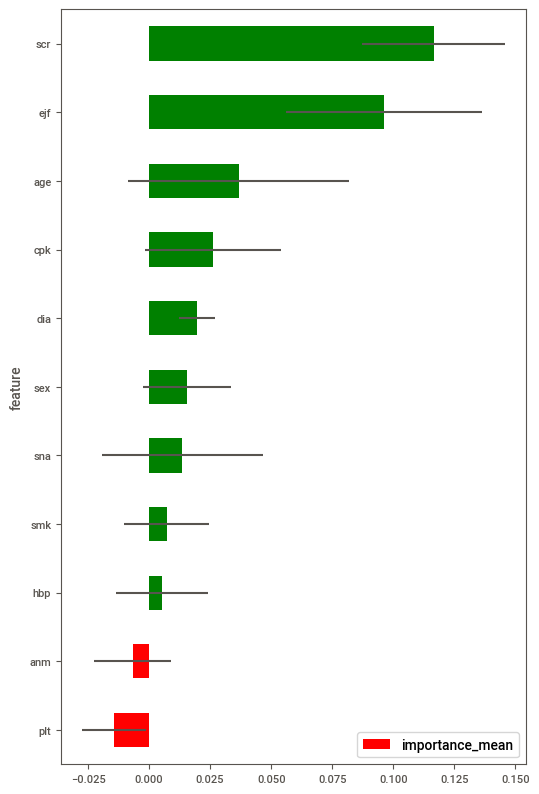

In [10]:
# Зададим нашу целевую переменную и признаки
dataset = Dataset(df=df, target='death', features=[col for col in df.columns if col != 'death'])

# Зададил схему валидации
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Зададим метрику, по которой будем определять качество модели
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="roc_auc")

# Получим среднее и значение и стандартное отклонение показателя важности
importance_df = lofo_imp.get_importance()

# Построим на графике показатели важности
plot_importance(importance_df, figsize=(6,10))

Мы видим, что самый значительный вклад в изменение метрики вносят признаки: Serum Creatinine, Ejection Fraction, Age. Зафиксируем это и перейдем ко второй части.

# Feature Selection Part 2

In [11]:
# Разделим датасет на X (фичи) и y (целевую переменную)

y = df['death'].values
X = df.drop(['death'], axis=1)

Попробуем провести отбор фичей с помощью GenericUnivariateSelect из sklearn, ориентируясь на следующую схему.

![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/11/How-to-Choose-Feature-Selection-Methods-For-Machine-Learning.png)

Сначала разберемся с количественными переменными. Посчитаем параметр ANOVA F-value для всех количественных переменных.

In [12]:
selection_num = GenericUnivariateSelect(f_classif, mode='k_best', param=3)
X_num = selection_num.fit_transform(X[['age', 'plt', 'ejf', 'cpk', 'scr', 'sna']], y)
display(selection_num.scores_)
display(X_num.shape)

array([20.43594646,  0.71888045, 23.09406305,  1.17325872, 28.15849226,
       11.76533129])

(299, 3)

В итоге видим, что самые высокие значения ANOVA F-value имеют следующие признаки: Age, Ejection Fraction, Serum Creatinine.

Теперь перейдем к категориальным признакам. Посчитаем параметр mutual_info_classif для категориальных переменных.

In [13]:
# Закодируем категориальные признаки с помощью OrdinalEncoder

def prepare_inputs(df_orig):
    oe = OrdinalEncoder()
    oe.fit(df_orig)
    df_enc = oe.transform(df_orig)
    return df_enc

X_cat = prepare_inputs(X[['sex', 'smk', 'dia', 'hbp', 'anm']])

In [14]:
selection_cat = GenericUnivariateSelect(mutual_info_classif, mode='k_best', param=3)
X_cat = selection_cat.fit_transform(X_cat, y)
display(selection_cat.scores_)
display(X_cat.shape)

array([0.        , 0.        , 0.00225588, 0.04573215, 0.04485149])

(299, 3)

Очевидно, что самые высокие значения ANOVA F-value имеют следующие признаки: Heart Blood Pressure, Anemia.

Суммировав первую и вторую часть отбора признаков делаем вывод, что в датасете требуется оставить следующие признаки + целевую переменную:
Age, Ejection Fraction, Serum Creatinine, Heart Blood Pressure, Anemia, Death.

In [15]:
df = df[['age', 'ejf', 'scr', 'hbp', 'anm', 'death']]
df.sample(5)

,age,ejf,scr,hbp,anm,death
241,65.000,30,1.3,No,No,No
277,70.000,38,1.1,No,No,No
33,50.000,30,1.2,No,Yes,No
53,70.000,50,1.0,Yes,Yes,Yes
185,60.667,30,1.5,No,Yes,Yes


# PyCaret

Для построения и модели мы будем использовать библиотеку PyCaret. Это библиотека машинного обучения с открытым исходным кодом на Python для обучения и развертывания моделей с учителем и без учителя в low-code среде.

По сравнению с другими открытыми библиотеками машинного обучения, PyCaret – это low-code альтернатива, которая поможет заменить сотни строк кода всего парой слов. Это позволяет значительно сократить время создания и оптимизации модели.

PyCaret проста и удобна в использовании. Все операции, выполняемые PyCaret, последовательно сохраняются в пайплайне полностью готовом для развертывания. Будь то добавление пропущенных значений, преобразование категориальных данных, инженерия признаков или оптимизация гиперпараметров, PyCaret сможет все это автоматизировать.

In [16]:
# Откопируем датасет
df_copy = df.copy()

In [17]:
# Создаем конфгурацию для движка сравнения моделей МО
grid = setup(data=df_copy, target=df_copy.columns[-1], train_size=0.90, # на валидационную выборку выделяем 10%,
             html=True, silent=True, verbose=False, session_id=42,
             preprocess=True,
             fix_imbalance=True, #применяем опцию fix_imbalance, которая применяет технику Synthetic Minority Over-sampling Technique
             
             categorical_features=['hbp', 'anm'], #определяем категориальные и числовые фичи
             numeric_features=['age', 'ejf', 'scr'],

#             normalize=True, normalize_method='robust', 
#             transformation=True, transformation_method='quantile',
#             pca=True, pca_method='linear', pca_components=5,
             
             polynomial_features=True, polynomial_degree=3, #включаем генерацию полиномиальных и тригонометрических признаков и их селекцию с определенным порогом
             trigonometry_features=True,
             polynomial_threshold=0.05,
             
             feature_interaction=True, #включаем генерацию interaction-признаков и их селекцию с определенным порогом
             feature_ratio=True,
             interaction_threshold=0.1,

#             feature_selection=True, feature_selection_threshold=0.3, feature_selection_method='boruta', #настраиваем итоговую селекцию признаков
             
             data_split_shuffle=True,
             data_split_stratify=True,
            )

Выбор метрики.

Проанализировав несколько статей по схожим проектам МО (например https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7), я пришел к выводу, что правильнее всего будет использовать метрику MCC (Matthews correlation coefficient) как основную. Так как она является более надежным статистическим показателем, которая выдает высокое значение только в том случае, если прогноз получил хорошие результаты во всех четырех категориях матрицы путаницы (истинные положительные, ложные отрицательные, истинные отрицательные и ложные положительные), ***пропорционально как размеру положительных элементов, так и размеру отрицательных элементов в наборе данных***. Метрику AUC будем использовать как дополнительное подтверждение.

Сравним производительность разных моделей МО на 10-ти фолдовой кросс-валидации.

In [18]:
# Запустим задачу сравнения производительности множества моделей МО
best = compare_models(sort='MCC', fold=10, n_select=1, turbo=False)
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7395,0.0000,0.6500,0.5799,0.6082,0.4147,0.4206,0.0200
lr,Logistic Regression,0.7248,0.7363,0.6958,0.5560,0.6134,0.4050,0.4149,0.1630
lda,Linear Discriminant Analysis,0.7358,0.7337,0.6125,0.5900,0.5954,0.4002,0.4049,0.0210
ada,Ada Boost Classifier,0.7285,0.7540,0.6056,0.5781,0.5872,0.3865,0.3898,0.0850
rf,Random Forest Classifier,0.7249,0.7796,0.6264,0.5629,0.5864,0.3821,0.3895,0.3510
lightgbm,Light Gradient Boosting Machine,0.7359,0.7922,0.5681,0.5855,0.5712,0.3815,0.3854,0.0490
et,Extra Trees Classifier,0.7325,0.7559,0.5764,0.5755,0.5713,0.3773,0.3814,0.3130
gbc,Gradient Boosting Classifier,0.7209,0.7623,0.5403,0.5561,0.5425,0.3430,0.3462,0.1320
catboost,CatBoost Classifier,0.7137,0.7808,0.5431,0.5526,0.5444,0.3360,0.3385,3.7870
xgboost,Extreme Gradient Boosting,0.7027,0.7700,0.5222,0.5306,0.5193,0.3065,0.3113,0.8100


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=42, solver='auto',
                tol=0.001)


В результате видим, что максимальное значение метрики  MCC достигнуто моделью LDA.

Но для дальнешего исследования и оптимизации я выберу модель на основе RF.

In [19]:
# Создадим модель на основе лучшей по результатам сравнения
clf = create_model('rf', fold=10)
print(clf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7778,0.7500,0.8750,0.5833,0.7000,0.5345,0.5622
1,0.6667,0.7467,0.5000,0.4444,0.4706,0.2286,0.2294
2,0.7037,0.8059,0.5000,0.5000,0.5000,0.2895,0.2895
3,0.7778,0.8241,0.5556,0.7143,0.6250,0.4706,0.4781
4,0.6296,0.8086,0.5556,0.4545,0.5000,0.2105,0.2132
5,0.7778,0.8457,0.8889,0.6154,0.7273,0.5500,0.5766
6,0.6667,0.7099,0.4444,0.5000,0.4706,0.2286,0.2294
7,0.8148,0.8827,0.7778,0.7000,0.7368,0.5946,0.5966
8,0.7037,0.7623,0.6667,0.5455,0.6000,0.3684,0.3731
9,0.7308,0.6597,0.5000,0.5714,0.5333,0.3453,0.3468


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


Визуально оценим производительность модели. В этом нам поможем дашборд PyCaret, который создается с помощью команды evaluate_model.

In [20]:
evaluate_model(clf)

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None


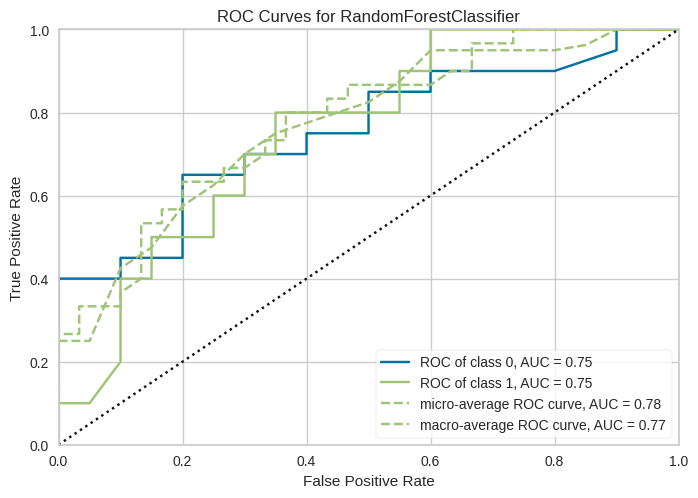

In [21]:
plot_model(clf, plot = 'auc')

Теперь проведем тюнинг модели в автоматическом режиме (метрика - MCC (среднее значение + стандартное отклонение), 10-ти фолдовая кросс-валидация)

In [22]:
tuned = tune_model(clf, optimize='mcc', n_iter=30, fold=10, search_library='optuna', search_algorithm='tpe', choose_better=True)
print(tuned)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6667,0.7467,0.7500,0.4615,0.5714,0.3231,0.3487
1,0.7407,0.7730,0.8750,0.5385,0.6667,0.4735,0.5110
2,0.8148,0.8947,1.0000,0.6154,0.7619,0.6240,0.6734
3,0.7778,0.6605,0.6667,0.6667,0.6667,0.5000,0.5000
4,0.7037,0.8395,0.7778,0.5385,0.6364,0.4000,0.4193
5,0.6667,0.8241,0.7778,0.5000,0.6087,0.3415,0.3669
6,0.7407,0.8272,0.7778,0.5833,0.6667,0.4615,0.4743
7,0.7778,0.8951,0.8889,0.6154,0.7273,0.5500,0.5766
8,0.7407,0.8210,0.7778,0.5833,0.6667,0.4615,0.4743
9,0.6923,0.7014,0.8750,0.5000,0.6364,0.4023,0.4501


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=3, max_features=0.6647810551335849,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.028874097921399108,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=4, min_weight_fraction_leaf=0.0,
                       n_estimators=280, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)


In [23]:
evaluate_model(tuned)

,Parameters
bootstrap,False
ccp_alpha,0.0
class_weight,balanced_subsample
criterion,entropy
max_depth,3
max_features,0.6647810551335849
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.028874097921399108
min_impurity_split,None


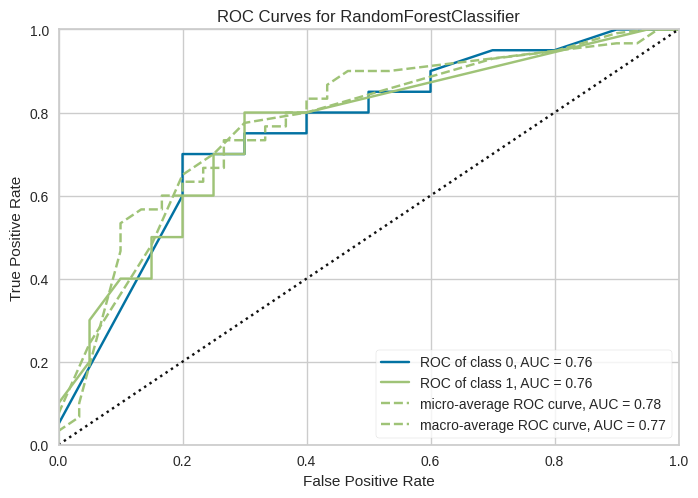

In [24]:
plot_model(tuned, plot = 'auc')

После тюнинга мы достигли небольшого улучшения по MCC и AUC c таким же небольшим увеличением стандартного отклонения от среднего значения.

Далее откалибруем модель. При выполнении классификационных экспериментов часто требуется предсказать не только метки классов, но и получить вероятность предсказания. Эта вероятность дает нам некоторую уверенность. Хорошо откалиброванные классификаторы - это вероятностные классификаторы, для которых выход вероятности может быть непосредственно интерпретирован как уровень достоверности.

In [25]:
calibrated = calibrate_model(tuned, fold=10)
print(calibrated)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7037,0.7434,0.7500,0.5000,0.6000,0.3793,0.3990
1,0.7407,0.7697,0.8750,0.5385,0.6667,0.4735,0.5110
2,0.8148,0.8750,0.8750,0.6364,0.7368,0.5994,0.6175
3,0.7778,0.6852,0.6667,0.6667,0.6667,0.5000,0.5000
4,0.7778,0.8210,0.8889,0.6154,0.7273,0.5500,0.5766
5,0.6667,0.8333,0.7778,0.5000,0.6087,0.3415,0.3669
6,0.7037,0.8210,0.6667,0.5455,0.6000,0.3684,0.3731
7,0.7778,0.8951,0.8889,0.6154,0.7273,0.5500,0.5766
8,0.7407,0.7963,0.7778,0.5833,0.6667,0.4615,0.4743
9,0.6923,0.6910,0.7500,0.5000,0.6000,0.3659,0.3858


CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=False,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced_subsample',
                                                             criterion='entropy',
                                                             max_depth=3,
                                                             max_features=0.6647810551335849,
                                                             max_leaf_nodes=None,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.028874097921399108,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_sa

In [26]:
evaluate_model(calibrated)

,Parameters
base_estimator,"RandomForestClassifier(bootstrap=False, ccp_al..."
cv,"StratifiedKFold(n_splits=10, random_state=42, ..."
method,sigmoid


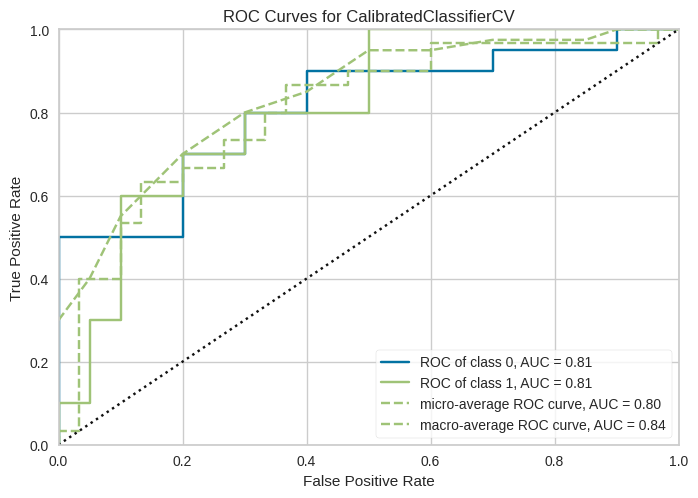

In [27]:
plot_model(calibrated, plot = 'auc')

После выполнения калибровки мы получили немного более правильную калибровочную кривую, а также уменьшение стандартного отклонения в обеих метриках.

Предскажем значения целевой переменной на отложенной 10%-ой выборке с помощью тюнингованной и откалиброванной моделей.

In [28]:
predict_model(clf)
predict_model(tuned)
predict_model(calibrated)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7000,0.7525,0.5000,0.5556,0.5263,0.3077,0.3086


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7333,0.7600,0.8000,0.5714,0.6667,0.4545,0.4725


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7333,0.8100,0.8000,0.5714,0.6667,0.4545,0.4725


,age,ejf,scr,cos(scr),ejf_Power3,scr_Power3,hbp_No,anm_No,cos(scr)_multiply_ejf,cos(scr)_multiply_age,...,age_divide_ejf_Power3,cos(scr)_divide_age,ejf_Power3_multiply_age,age_divide_cos(scr),age_divide_ejf,ejf_Power3_multiply_scr,scr_multiply_age,death,Label,Score
0,70.0,60.0,1.10,0.453596,216000.0,1.331000,0.0,0.0,27.215767,31.751728,...,0.000324,0.006480,15120000.0,154.322311,1.166667,237600.000000,77.000000,No,No,0.5784
1,65.0,25.0,1.30,0.267499,15625.0,2.197000,0.0,0.0,6.687472,17.387426,...,0.004160,0.004115,1015625.0,242.991669,2.600000,20312.500000,84.500000,No,Yes,0.6844
2,60.0,38.0,0.75,0.731689,54872.0,0.421875,1.0,1.0,27.804176,43.901333,...,0.001093,0.012195,3292320.0,82.002068,1.578947,41154.000000,45.000000,No,No,0.8562
3,80.0,35.0,2.10,-0.504846,42875.0,9.260999,1.0,1.0,-17.669611,-40.387684,...,0.001866,-0.006311,3430000.0,-158.464157,2.285714,90037.492188,168.000000,No,Yes,0.7447
4,50.0,45.0,1.00,0.540302,91125.0,1.000000,1.0,0.0,24.313602,27.015114,...,0.000549,0.010806,4556250.0,92.540794,1.111111,91125.000000,50.000000,No,No,0.8527
5,42.0,40.0,1.20,0.362358,64000.0,1.728000,1.0,1.0,14.494309,15.219025,...,0.000656,0.008628,2688000.0,115.907555,1.050000,76800.000000,50.400002,No,No,0.8558
6,70.0,17.0,1.00,0.540302,4913.0,1.000000,0.0,1.0,9.185139,37.821159,...,0.014248,0.007719,343910.0,129.557114,4.117647,4913.000000,70.000000,No,Yes,0.8822
7,55.0,25.0,1.10,0.453596,15625.0,1.331000,1.0,1.0,11.339903,24.947786,...,0.003520,0.008247,859375.0,121.253242,2.200000,17187.500000,60.500000,Yes,Yes,0.7047
8,86.0,38.0,1.83,-0.256311,54872.0,6.128488,1.0,1.0,-9.739816,-22.042740,...,0.001567,-0.002980,4718992.0,-335.529968,2.263158,100415.765625,157.380005,Yes,Yes,0.7430
9,45.0,35.0,1.00,0.540302,42875.0,1.000000,1.0,1.0,18.910580,24.313602,...,0.001050,0.012007,1929375.0,83.286713,1.285714,42875.000000,45.000000,Yes,No,0.8557


Финализируем и сохраним нашу модель для дальнешего развертывания.

In [29]:
final_clf = finalize_model(calibrated)
save_model(final_clf, model_name = 'rds_diploma')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['hbp', 'anm'],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['age', 'ejf', 'scr'],
                                       target='death', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_...
                                                                               max_leaf_nodes=None,
                                                                               max_samples=None,
                                                                               min_impurity_decrease=0.02887

# БОНУС. Ансамблирование, блендинг, стекинг и вот всё :)

К сожалению, пока удалось попробовать только анасамблирование методом бустинга.

In [30]:
boosted_clf = ensemble_model(calibrated, method = 'Boosting')
predict_model(boosted_clf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7037,0.7632,0.7500,0.5000,0.6000,0.3793,0.3990
1,0.7037,0.7237,0.7500,0.5000,0.6000,0.3793,0.3990
2,0.8519,0.9211,0.7500,0.7500,0.7500,0.6447,0.6447
3,0.7407,0.6667,0.5556,0.6250,0.5882,0.4000,0.4015
4,0.6667,0.8519,0.5556,0.5000,0.5263,0.2703,0.2712
5,0.7037,0.8519,0.7778,0.5385,0.6364,0.4000,0.4193
6,0.7778,0.8642,0.6667,0.6667,0.6667,0.5000,0.5000
7,0.8148,0.8457,0.8889,0.6667,0.7619,0.6154,0.6325
8,0.5556,0.5926,0.2222,0.2857,0.2500,-0.0588,-0.0598
9,0.6154,0.6597,0.3750,0.3750,0.3750,0.0972,0.0972


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7333,0.7250,0.6000,0.6000,0.6000,0.4000,0.4000


,age,ejf,scr,cos(scr),ejf_Power3,scr_Power3,hbp_No,anm_No,cos(scr)_multiply_ejf,cos(scr)_multiply_age,...,age_divide_ejf_Power3,cos(scr)_divide_age,ejf_Power3_multiply_age,age_divide_cos(scr),age_divide_ejf,ejf_Power3_multiply_scr,scr_multiply_age,death,Label,Score
0,70.0,60.0,1.10,0.453596,216000.0,1.331000,0.0,0.0,27.215767,31.751728,...,0.000324,0.006480,15120000.0,154.322311,1.166667,237600.000000,77.000000,No,No,0.5311
1,65.0,25.0,1.30,0.267499,15625.0,2.197000,0.0,0.0,6.687472,17.387426,...,0.004160,0.004115,1015625.0,242.991669,2.600000,20312.500000,84.500000,No,Yes,0.5238
2,60.0,38.0,0.75,0.731689,54872.0,0.421875,1.0,1.0,27.804176,43.901333,...,0.001093,0.012195,3292320.0,82.002068,1.578947,41154.000000,45.000000,No,No,0.5573
3,80.0,35.0,2.10,-0.504846,42875.0,9.260999,1.0,1.0,-17.669611,-40.387684,...,0.001866,-0.006311,3430000.0,-158.464157,2.285714,90037.492188,168.000000,No,Yes,0.5176
4,50.0,45.0,1.00,0.540302,91125.0,1.000000,1.0,0.0,24.313602,27.015114,...,0.000549,0.010806,4556250.0,92.540794,1.111111,91125.000000,50.000000,No,No,0.5526
5,42.0,40.0,1.20,0.362358,64000.0,1.728000,1.0,1.0,14.494309,15.219025,...,0.000656,0.008628,2688000.0,115.907555,1.050000,76800.000000,50.400002,No,No,0.5639
6,70.0,17.0,1.00,0.540302,4913.0,1.000000,0.0,1.0,9.185139,37.821159,...,0.014248,0.007719,343910.0,129.557114,4.117647,4913.000000,70.000000,No,Yes,0.5766
7,55.0,25.0,1.10,0.453596,15625.0,1.331000,1.0,1.0,11.339903,24.947786,...,0.003520,0.008247,859375.0,121.253242,2.200000,17187.500000,60.500000,Yes,No,0.5011
8,86.0,38.0,1.83,-0.256311,54872.0,6.128488,1.0,1.0,-9.739816,-22.042740,...,0.001567,-0.002980,4718992.0,-335.529968,2.263158,100415.765625,157.380005,Yes,Yes,0.5039
9,45.0,35.0,1.00,0.540302,42875.0,1.000000,1.0,1.0,18.910580,24.313602,...,0.001050,0.012007,1929375.0,83.286713,1.285714,42875.000000,45.000000,Yes,No,0.5638
